# Data Analysis for RQ2

In [10]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [11]:
# Load the datasets
file_path = "data/videos/"
rr = pd.read_csv(os.path.join(file_path, 'analysis_report_RR.csv'))
rm = pd.read_csv(os.path.join(file_path, 'analysis_report_RM.csv'))
mr = pd.read_csv(os.path.join(file_path, 'analysis_report_MR.csv'))
mm = pd.read_csv(os.path.join(file_path, 'analysis_report_MM.csv'))

# Label matchups
rr['Matchup'] = 'RR'
rm['Matchup'] = 'RM'
mr['Matchup'] = 'MR'
mm['Matchup'] = 'MM'

matchup_dfs = {
    "MM": mm,
    "MR": mr,
    "RM": rm,
    "RR": rr
}

# Combine datasets
all_data = pd.concat([rr, rm, mr, mm], ignore_index=True)

def load_and_process(target, label):
    df = target
    df['Matchup'] = label
    df['game_time'] = df['video_timestamp'].apply(parse_timestamp)
    df['gold_diff'] = df['gold'].diff().fillna(0)
    df['minion_diff'] = df['minions'].diff().fillna(0)
    return df

# Parse timestamp to seconds
def parse_timestamp(ts):
    parts = ts.split(':')
    try:
        return int(parts[0]) * 3600 + int(parts[1]) * 60 + float(parts[2])
    except:
        return None

all_data['seconds'] = all_data['video_timestamp'].apply(parse_timestamp)

# === Configuration ===
WAVE_INTERVAL = 30
TARGET_TIME = 600  # 10-minute mark
TOLERANCE = 1
USE_FLIP_FLOP = True  # Enable alternating extra minion assignment

# Minion gold values at base and scaling per 90s
MINION_VALUES = {
    'melee': {'base': 21, 'scaling': 3},
    'caster': {'base': 14, 'scaling': 3},
    'siege': {'base': 60, 'scaling': 3}
}

In [15]:
def minion_gold(game_time, minion_type):
    scaling = game_time // 90
    return MINION_VALUES[minion_type]['base'] + MINION_VALUES[minion_type]['scaling'] * scaling

def gold_at_10_min(minion_type):
    return MINION_VALUES[minion_type]['base'] + MINION_VALUES[minion_type]['scaling'] * (600 // 90)

# --- Precomputed Maximum Gold for 10 minutes ---
max_gold_10min = 0
for t in range(65, 601, WAVE_INTERVAL):
    wave_num = (t - 65) // WAVE_INTERVAL
    scaling = t // 90
    gold_wave = (
        3 * (MINION_VALUES['melee']['base'] + scaling * MINION_VALUES['melee']['scaling']) +
        3 * (MINION_VALUES['caster']['base'] + scaling * MINION_VALUES['caster']['scaling']) +
        (1 if wave_num % 3 == 2 else 0) *
        (MINION_VALUES['siege']['base'] + scaling * MINION_VALUES['siege']['scaling'])
    )
    max_gold_10min += gold_wave

summary_rows = []

for matchup, target in matchup_dfs.items():
    df = load_and_process(target, matchup)

    # Extract snapshot at 10 minutes
    df_10min = df[(df['game_time'] >= TARGET_TIME - TOLERANCE) & (df['game_time'] <= TARGET_TIME + TOLERANCE)]
    avg_minions = df_10min['minions'].mean()

    # Process minion kill events
    df_valid = df[(df['gold_diff'] > 0) & (df['minion_diff'] > 0)]
    minion_counts = {'melee': 0, 'caster': 0, 'siege': 0}
    assign_extra_to_caster = True  # flip-flop toggle

    for _, row in df_valid.iterrows():
        m = int(row['minion_diff'])
        g = row['gold_diff']
        t = row['game_time']
        if m <= 0 or g <= 0:
            continue

        avg_m_value = g / m
        siege_val = minion_gold(t, 'siege')

        # Detect siege
        siege_count = 0
        if avg_m_value >= siege_val - 5:
            siege_count = 1 if m >= 1 else 0
            m -= siege_count
            g -= siege_count * siege_val

        # Distribute melee and caster
        if m > 0:
            base = m // 2
            extra = m % 2
            if USE_FLIP_FLOP:
                if assign_extra_to_caster:
                    caster_share = base + extra
                    melee_share = base
                else:
                    caster_share = base
                    melee_share = base + extra
                assign_extra_to_caster = not assign_extra_to_caster
            else:
                caster_share = (m + 1) // 2
                melee_share = m - caster_share

            minion_counts['melee'] += melee_share
            minion_counts['caster'] += caster_share
        minion_counts['siege'] += siege_count

    # Recalculate gold using inferred minion counts and 10-min gold values
    inferred_gold = (
        minion_counts['melee'] * gold_at_10_min('melee') +
        minion_counts['caster'] * gold_at_10_min('caster') +
        minion_counts['siege'] * gold_at_10_min('siege')
    )

    wave_efficiency = inferred_gold / max_gold_10min if max_gold_10min > 0 else 0

    summary_rows.append({
        "Matchup": matchup,
        "Minions Killed": round(avg_minions, 1),
        "Melee": minion_counts['melee'],
        "Caster": minion_counts['caster'],
        "Siege": minion_counts['siege'],
        "Inferred Gold": round(inferred_gold, 1),
        "Max Gold (10min)": round(max_gold_10min, 1),
        "Wave Efficiency": round(wave_efficiency, 3)
    })

# === Output Summary Table ===
summary_df = pd.DataFrame(summary_rows)
print(summary_df)

# Optional: Export LaTeX
latex = summary_df.to_latex(
    index=False,
    caption="Inferred Minion Type and Gold Distribution at 10 Minutes",
    label="tab:minion_gold_table"
)
print(latex)

# === Output Summary Table ===
summary_df = pd.DataFrame(summary_rows)
print(summary_df)

# Export to CSV
summary_df.to_csv("minion_gold_summary.csv", index=False)
print("Summary table exported to 'minion_gold_summary.csv'")

# Optional: Export LaTeX
latex = summary_df.to_latex(
    index=False,
    caption="Inferred Minion Type and Gold Distribution at 10 Minutes",
    label="tab:minion_gold_table"
)
print(latex)

# Save LaTeX to a file
with open("minion_gold_summary.tex", "w") as f:
    f.write(latex)
print("LaTeX table exported to 'minion_gold_summary.tex'")


  Matchup  Minions Killed  Melee  Caster  Siege  Inferred Gold  \
0      MM            51.0     37      39      5           3081   
1      MR            54.0     23      27      2           1917   
2      RM            66.7     32      31      5           2630   
3      RR            63.0     30      30      3           2364   

   Max Gold (10min)  Wave Efficiency  
0              3339            0.923  
1              3339            0.574  
2              3339            0.788  
3              3339            0.708  
\begin{table}
\caption{Inferred Minion Type and Gold Distribution at 10 Minutes}
\label{tab:minion_gold_table}
\begin{tabular}{lrrrrrrr}
\toprule
Matchup & Minions Killed & Melee & Caster & Siege & Inferred Gold & Max Gold (10min) & Wave Efficiency \\
\midrule
MM & 51.000000 & 37 & 39 & 5 & 3081 & 3339 & 0.923000 \\
MR & 54.000000 & 23 & 27 & 2 & 1917 & 3339 & 0.574000 \\
RM & 66.700000 & 32 & 31 & 5 & 2630 & 3339 & 0.788000 \\
RR & 63.000000 & 30 & 30 & 3 & 2364 & 3339

<Figure size 1000x600 with 0 Axes>

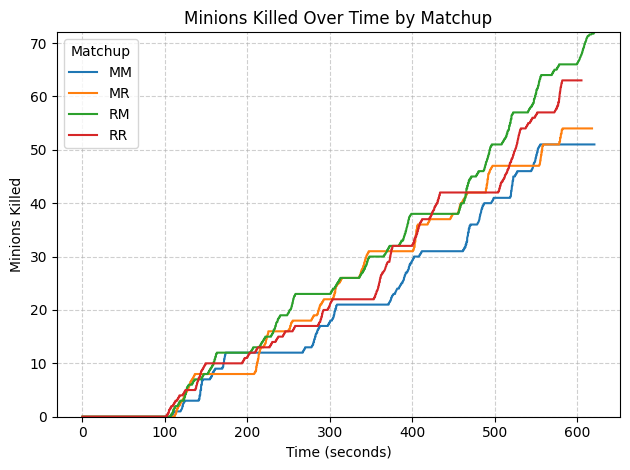

In [14]:
# Sort and calculate minion difference
all_data_sorted = all_data.sort_values(by=['Matchup', 'seconds']).reset_index(drop=True)
all_data_sorted['minion_diff'] = all_data_sorted.groupby('Matchup')['minions'].diff().fillna(0)

# Filter for valid farming data:
#  - No negative minion difference (should be monotonically increasing)
#  - No unrealistically large jumps (>4 minions in one second)
valid_data = all_data_sorted[
    (all_data_sorted['minion_diff'] >= 0) & 
    (all_data_sorted['minion_diff'] <= 4)
]

# Aggregate: Average minions over time by matchup
valid_cs_over_time = valid_data.groupby(['Matchup', 'seconds'])['minions'].mean().reset_index()

# Pivot for easy plotting
valid_cs_over_time_pivot = valid_cs_over_time.pivot(index='seconds', columns='Matchup', values='minions')

# Smooth and plot
smoothing_window = 15  # Rolling window to smooth curves

plt.figure(figsize=(10, 6))
(valid_cs_over_time_pivot.rolling(window=smoothing_window, min_periods=1).mean()).plot()

plt.title('Minions Killed Over Time by Matchup')
plt.xlabel('Time (seconds)')
plt.ylabel('Minions Killed')
plt.ylim(0, 72)  # Set y-axis limit to match expected farming at 10min
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Matchup')
plt.tight_layout()
plt.savefig('minions_killed_over_time_by_matchup.png')
plt.show()


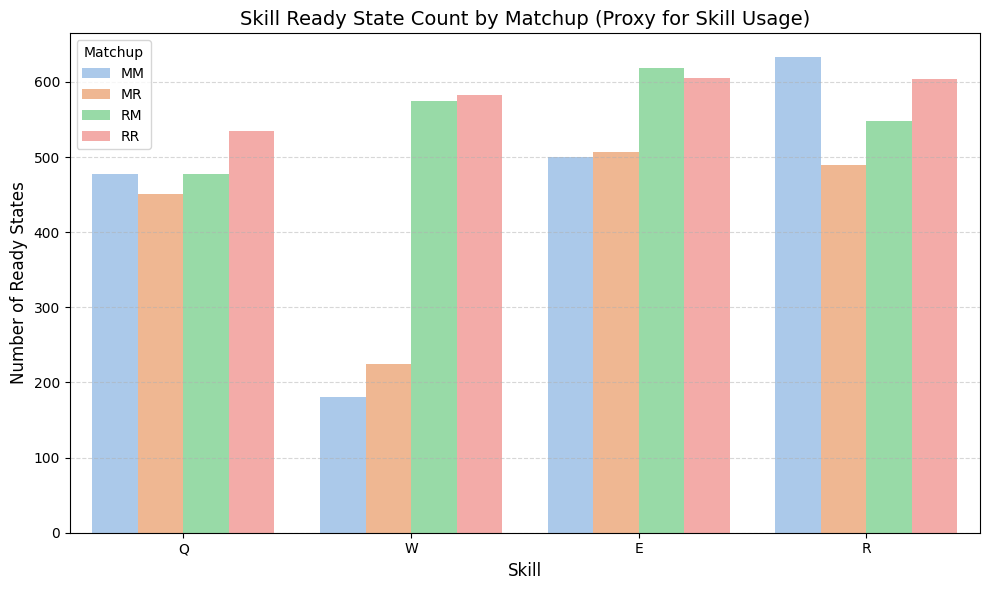

In [6]:
# Count "Ready" states for each skill by matchup
skill_ready_counts = []

for matchup, df in matchup_dfs.items():
    for skill in ['Q', 'W', 'E', 'R']:
        count = (df[skill] == 'Ready').sum()
        skill_ready_counts.append({
            'Matchup': matchup,
            'Skill': skill,
            'ReadyCount': count
        })

# Step 3: Convert to DataFrame
skill_df = pd.DataFrame(skill_ready_counts)

# Step 4: Plot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=skill_df, x="Skill", y="ReadyCount", hue="Matchup", palette="pastel")

# Styling
plt.title("Skill Ready State Count by Matchup (Proxy for Skill Usage)", fontsize=14)
plt.xlabel("Skill", fontsize=12)
plt.ylabel("Number of Ready States", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Optional: save figure
plt.savefig("skill_ready_state_by_matchup.png", dpi=300)
plt.show()

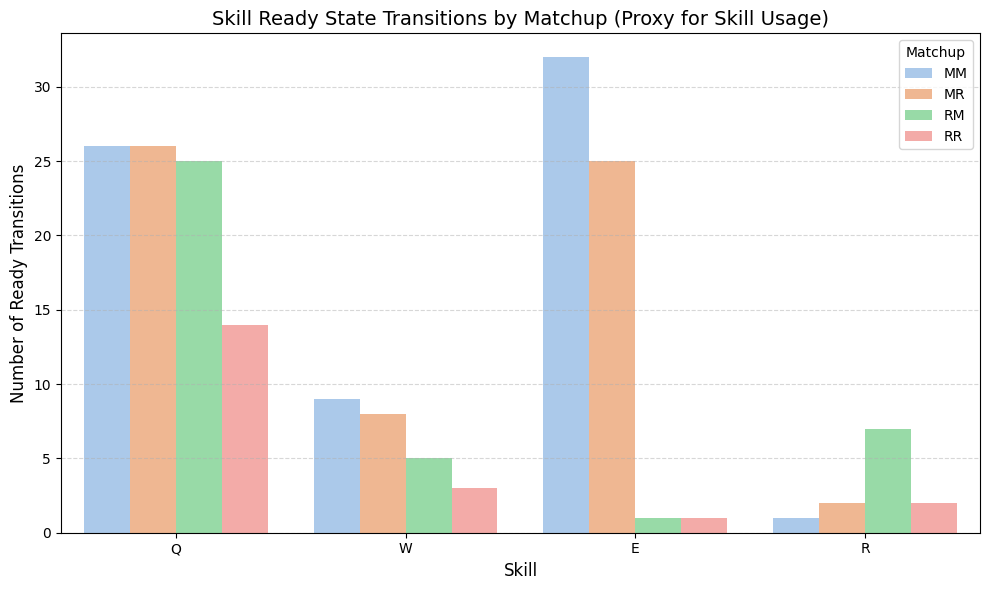

In [7]:
# Count transitions to "Ready" states for each skill by matchup
skill_ready_transitions = []

for matchup, df in matchup_dfs.items():
    for skill in ['Q', 'W', 'E', 'R']:
        # Count transitions where the current state is "Ready" and the previous state is not "Ready"
        transitions = df[skill].eq('Ready') & df[skill].shift(1).ne('Ready')
        count = transitions.sum()
        skill_ready_transitions.append({
            'Matchup': matchup,
            'Skill': skill,
            'ReadyTransitions': count
        })

# Step 3: Convert to DataFrame
skill_df = pd.DataFrame(skill_ready_transitions)

# Step 4: Plot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=skill_df, x="Skill", y="ReadyTransitions", hue="Matchup", palette="pastel")

# Styling
plt.title("Skill Ready State Transitions by Matchup (Proxy for Skill Usage)", fontsize=14)
plt.xlabel("Skill", fontsize=12)
plt.ylabel("Number of Ready Transitions", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Optional: save figure
plt.savefig("skill_ready_transitions_by_matchup.png", dpi=300)
plt.show()

In [8]:
skill_df

,Matchup,Skill,ReadyTransitions
0,MM,Q,26
1,MM,W,9
2,MM,E,32
3,MM,R,1
4,MR,Q,26
5,MR,W,8
6,MR,E,25
7,MR,R,2
8,RM,Q,25
9,RM,W,5


In [9]:
ser_data = []

for matchup, df in matchup_dfs.items():
    # Count transitions to "Ready" for Q and E
    q_ready_transitions = (df['Q'].eq('Ready') & df['Q'].shift(1).ne('Ready')).sum()
    e_ready_transitions = (df['E'].eq('Ready') & df['E'].shift(1).ne('Ready')).sum()
    ready_transitions_total = q_ready_transitions + e_ready_transitions

    # Total minions killed = last value in 'minions' column
    total_minions = df['minions'].max()

    # Calculate proxy SER using transitions
    proxy_ser = ready_transitions_total / total_minions if total_minions > 0 else 0

    ser_data.append({
        "Matchup": matchup,
        "Q+E Ready Transitions": ready_transitions_total,
        "Proxy SER": round(proxy_ser, 3)
    })

# Convert to DataFrame
ser_df = pd.DataFrame(ser_data)

# Optional: Output LaTeX table
latex = ser_df.to_latex(
    index=False,
    caption="Proxy Skill Execution Ratio (Q+E Transitions to Ready per Minion Killed) by Matchup",
    label="tab:proxy_ser"
)

print(ser_df)
print("\nLaTeX Table:")
print(latex)

  Matchup  Q+E Ready Transitions  Proxy SER
0      MM                     58      1.137
1      MR                     51      0.944
2      RM                     26      0.361
3      RR                     15      0.238

LaTeX Table:
\begin{table}
\caption{Proxy Skill Execution Ratio (Q+E Transitions to Ready per Minion Killed) by Matchup}
\label{tab:proxy_ser}
\begin{tabular}{lrr}
\toprule
Matchup & Q+E Ready Transitions & Proxy SER \\
\midrule
MM & 58 & 1.137000 \\
MR & 51 & 0.944000 \\
RM & 26 & 0.361000 \\
RR & 15 & 0.238000 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\hanxiao\AppData\Local\Temp\ipykernel_54788\185436045.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=ser_df, x="Matchup", y="Proxy SER", palette="pastel")


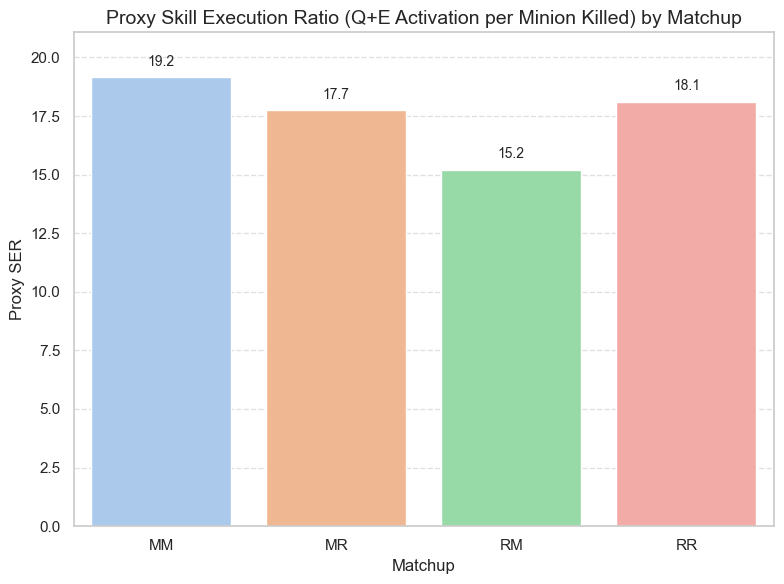

In [13]:
# Ensure seaborn style
sns.set(style="whitegrid")

# Plot the Proxy SER values
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=ser_df, x="Matchup", y="Proxy SER", palette="pastel")

# Styling
plt.title("Proxy Skill Execution Ratio (Q+E Activation per Minion Killed) by Matchup", fontsize=14)
plt.xlabel("Matchup", fontsize=12)
plt.ylabel("Proxy SER", fontsize=12)
plt.ylim(0, max(ser_df["Proxy SER"].max() * 1.1, 20))
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate bars with values
for index, row in ser_df.iterrows():
    ax.text(index, row["Proxy SER"] + 0.5, f"{row['Proxy SER']:.1f}", ha='center', fontsize=10)

# Save and display
plt.tight_layout()
plt.savefig("proxy_ser_by_matchup.png", dpi=300)
plt.show()